# Benchmark Analysis

This notebook generates a synthetic timeseries with a known bias, and applies basic analysis methods to remove it

In [1]:
import math
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '16'; font_size = 16
plt.style.use('default')

import periodic_sampling as ps

## Synthetic Data

In [2]:
# Simulate Renewal Model
time_steps = 100; N_0 = 100; seed=42; R0_diff = 0.25
start_date = '01/01/2020'; bias_method = 'scale'

bias = [0.5, 1.4, 1.2, 1.1, 1.1, 1.1, 0.6]  # Always given with monday first
R0_list = ([1.0 + R0_diff] * int(time_steps/2)) + ([1.0 - R0_diff] * int(time_steps/2))
images_path = "synthetic_inference/stepped_R/"

np.random.seed(seed)
model = ps.synthetic_data.RenewalModel()
model.simulate(T=time_steps, N_0=N_0, R_0=R0_list)

100%|██████████| 100/100 [00:00<00:00, 66145.78it/s]


In [3]:
# Report unbiased and biased data
rep = ps.synthetic_data.Reporter(model.case_data, start_date=start_date)  # Start on Mon 6th for ease

truth_df = rep.unbiased_report()
bias_df = rep.fixed_bias_report(bias=bias, method=bias_method)

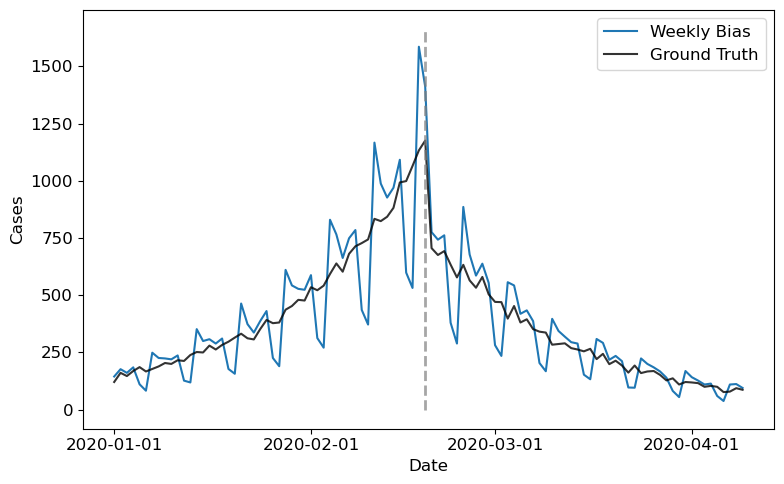

In [4]:
# Plot bias in data
fig, axs = plt.subplots(1, figsize=(8,5))

bias_df.plot(x='Date', y='Confirmed', ax=axs, color='tab:blue', label = 'Weekly Bias')
truth_df.plot(x='Date', y='Confirmed', ax=axs, color='black', label = 'Ground Truth', alpha=0.8)
mid_date = truth_df['Date'][int((len(truth_df['Date'])-1)/2)]
plt.vlines(x=mid_date, ymin=0, ymax=plt.gca().get_ylim()[1], color='grey', linewidth=2, linestyle = 'dashed', alpha = 0.7)
fig.patch.set_facecolor('white')  # Overrides VSCode dark mode default
plt.xlabel("Date"); plt.ylabel("Cases"); axs.set_xticks(axs.get_xticks()[::2]);
plt.legend(); plt.tight_layout()
# plt.savefig("../images/synthetic_inference/"
#             + f"biased_data_{bias_method}_T_{time_steps}_N0_{N_0}_R0_{R_0}_seed_{seed}.png")

## Timeseries Accuracy

Methods to quantify accuracy of true time series prediction - used throughout.

In [5]:
def rms(series):
    """Returns rms value for a series"""
    return np.power(np.sum(np.square(series)) / len(series), 1/2)

def calc_cross_corr(truth, bias):
    cross_corr = np.correlate(truth, bias, mode='full').astype('float64')
    cross_corr /= sum(cross_corr)
    # cross_corr = np.divide(cross_corr, list(range(1,len(cross_corr)+2,2)) + list(range(1,len(cross_corr),2))[::-1])  
    # Normalise by number of contributing elements from timeseries
    t_values = range(-len(truth) + 1, len(truth))
    return cross_corr, t_values

def calc_expected_lag(truth, bias):
    cross_corr, t_values = calc_cross_corr(truth, bias)
    return np.dot(t_values, cross_corr)

In [6]:
def rms_plots(data_series, labels):
    fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
    for i in range(len(data_series)):
        residual = data_series[i] - truth_df['Confirmed']
        axs[i].hist(residual, bins=20); axs[i].set_title(labels[i], fontsize=font_size)
        axs[i].tick_params(axis='both', which='major', labelsize=font_size)
        print(f"RMS Residual for {labels[i]} data: " + str(round(rms(residual), 2)))

    ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.ylabel("Frequency", fontsize=font_size); plt.xlabel('Residual', fontsize=font_size);
    plt.tight_layout()

In [7]:
def lab_plots(data_series, labels):
    fig, axs = plt.subplots(1, len(data_series), figsize=(12,4))
    for i in range(len(data_series)):
        cross_corr, t_values = calc_cross_corr(truth_df['Confirmed'], data_series[i])
        expected_lag = calc_expected_lag(truth_df['Confirmed'], data_series[i])
        
        axs[i].plot(t_values, cross_corr); axs[i].set_title(labels[i], fontsize=font_size)
        axs[i].set_xlim(-30, 30); #axs[i].set_yscale('log')
        axs[i].tick_params(axis='both', which='major', labelsize=font_size)
        print(f"Expected lag for {labels[i]} data: {-expected_lag:.2f} days")

    ax2 = fig.add_subplot(111, frameon=False); fig.patch.set_facecolor('white') 
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    axs[0].set_ylabel("Frequency", fontsize=font_size); plt.xlabel('Time offset (days)', fontsize=font_size);
    plt.tight_layout()

## Rolling Average

The section documents the estimation of the true data series, using a rolling 7 day average method (the government standard).

RMS Residual for Raw Data data: 142.65
RMS Residual for Rolling Average data: 84.14


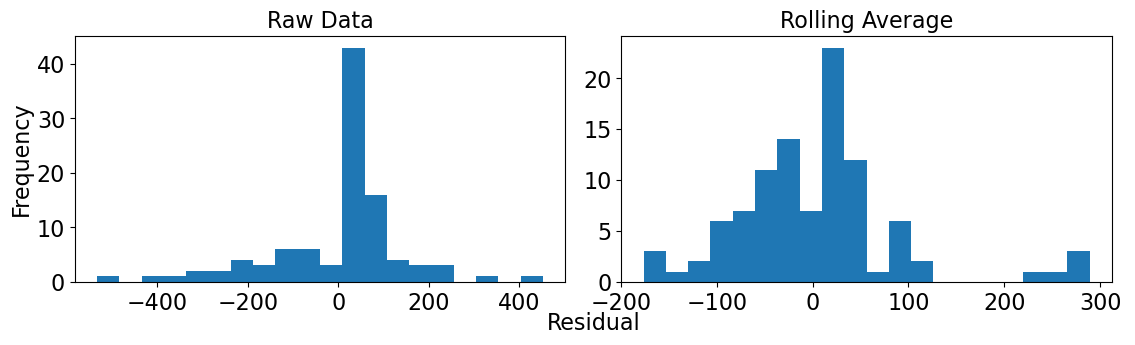

In [8]:
roll_ave_series = bias_df['Confirmed'].rolling(window=7).mean().bfill().ffill()

data_series = [bias_df['Confirmed'], roll_ave_series]
labels = ['Raw Data', 'Rolling Average']

rms_plots(data_series, labels)

Expected lag for Raw Data data: -0.02 days
Expected lag for Rolling Average data: 2.02 days


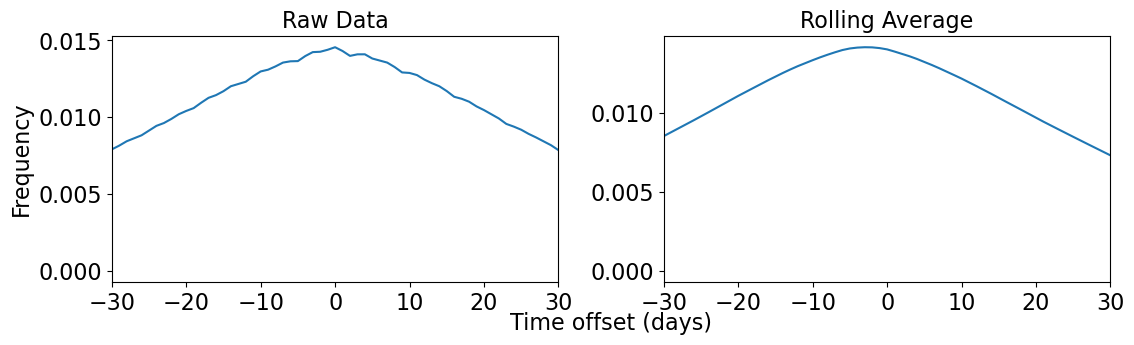

In [9]:
lab_plots(data_series, labels)

## Fourier Spectra

We will consider any periodicity in Fourier space. For this it is helpful to normalise the data - we will do this by introducing a relative reporting factor (greek letter tbc) which defines the scaling between the reported value and the true value. For data where the true value is not known (such as in this case), we compare to a 7-day rolling average (uniform window).

In [17]:
def plot_fourier_data(df, ax, label = 'Confirmed', compute_psd=True, cutoff=None, window=None):
    case_fft, case_freq = ps.analysis.fourier_transform(df, column='Dif_' + label, compute_psd=compute_psd)
    ps.analysis.plot_fft(case_fft, case_freq, ax=ax, color='tab:blue', label="Cases")
    if cutoff is not None:
        ax.axvspan(0, cutoff, facecolor='gray', alpha=0.3)
    if window is not None:
        a = window / 2
        ax.axvspan(0, 1-a, facecolor='gray', alpha=0.3)
        for n in range(1, math.floor(max(case_fft)) + 1):
            ax.axvspan(n+a, n+1-a, facecolor='gray', alpha=0.3)
    ax.set_xlabel(''); ax.set_xticklabels([]);

def calc_ifft(df, column, cutoff=None, window=None):
    data_fft, data_freq = ps.analysis.fourier_transform(df, column=column, compute_psd=False)
    data_crop_fft = data_fft.copy()
    if cutoff is not None:
        data_crop_fft[np.abs(data_freq) > cutoff] = 0
    if window is not None:
        a = window / 2
        for n in range(1, math.floor(max(data_freq)) + 1):
            data_crop_fft[((np.abs(data_freq) > (n-a))) & (np.abs(data_freq) < (n+a))] = 0
    return np.real(sp.fftpack.ifft(data_crop_fft))

def plot_ifft(df, column, ifft_data, ax, color, label):
    truth_df.plot.line('Date', column, color='gray', ax=ax, label='Ground Truth', alpha=0.7, legend=False)
    ax.plot(df['Date'], ifft_data, color=color, label=label)
    ax.legend(loc=2); ax.set_ylabel(label, color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.set_xlabel(''); ax.set_xticklabels([]);

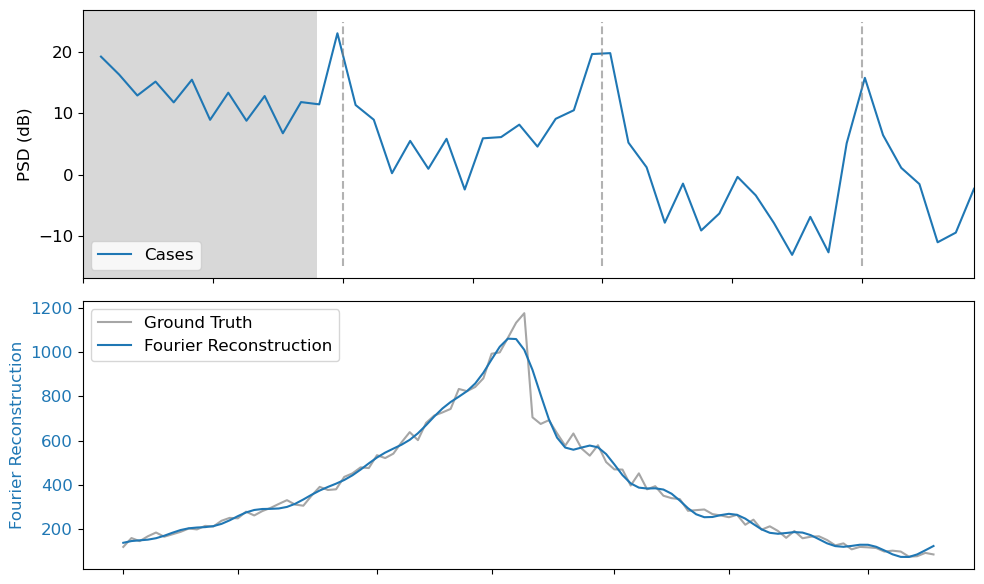

In [18]:
# Plot Fourier components of case data - using cutoff method

bias_df["Date"] = pd.to_datetime(bias_df["Date"], format = "%Y-%m-%d")
bias_df["Days"] = bias_df["Date"].apply(lambda date: (date - min(bias_df["Date"])).days)
df = ps.analysis.rel_reporting_calc(bias_df, ['Confirmed'])

fig, axs = plt.subplots(2, figsize=(10,6))
plot_fourier_data(df=df, ax=axs[0], cutoff=0.9)

ifft_data_cutoff = calc_ifft(df, 'Confirmed', cutoff=0.9)
plot_ifft(df, 'Confirmed', ifft_data_cutoff, ax=axs[1], color='tab:blue', label="Fourier Reconstruction")
fig.tight_layout()

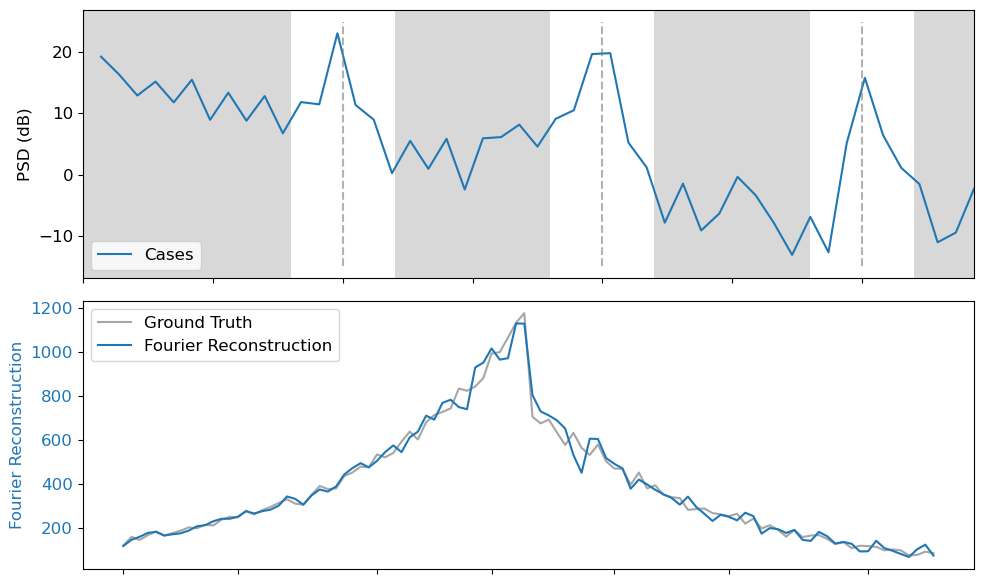

In [26]:
fig, axs = plt.subplots(2, figsize=(10,6))
plot_fourier_data(df, axs[0], window = 0.4)

ifft_data_window = calc_ifft(df, 'Confirmed', window = 0.4)
plot_ifft(df, 'Confirmed', ifft_data_window, ax=axs[1], color='tab:blue', label="Fourier Reconstruction")
fig.tight_layout()

RMS Residual for Raw Data data: 142.65
RMS Residual for Fourier Cutoff data: 36.95
RMS Residual for Fourier Window data: 35.2


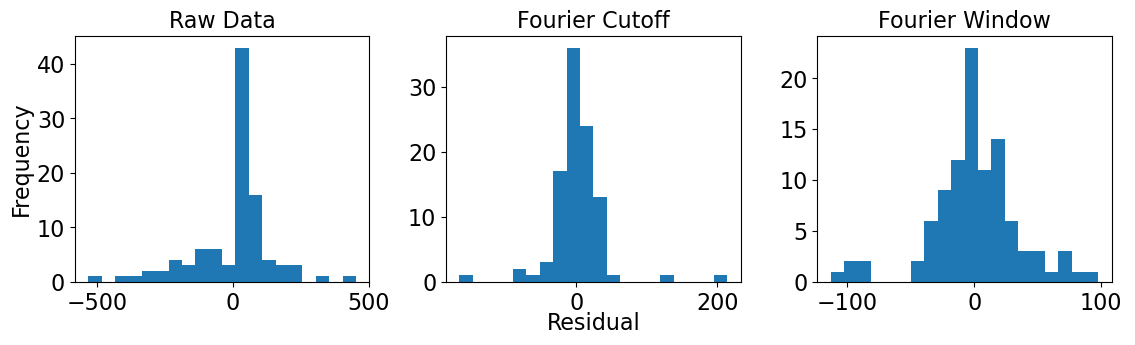

Expected lag for Raw Data data: -0.02 days
Expected lag for Fourier Cutoff data: 0.04 days
Expected lag for Fourier Window data: 0.02 days


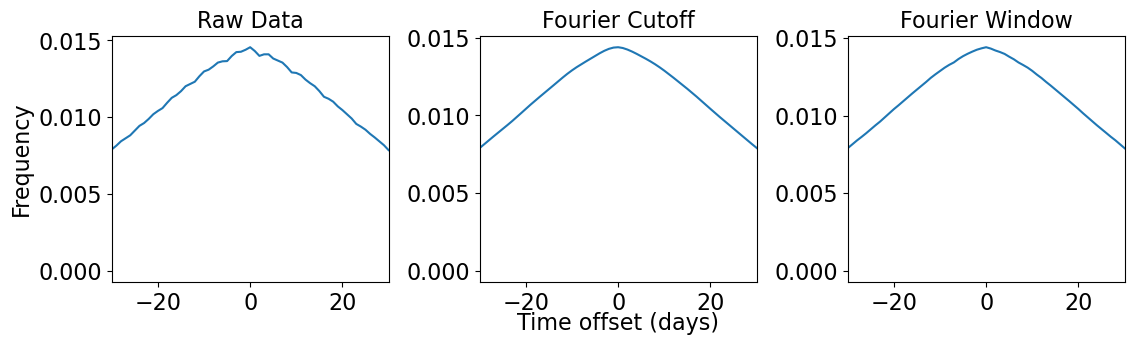

In [28]:
data_series = [bias_df['Confirmed'], ifft_data_cutoff, ifft_data_window]
labels = ['Raw Data', 'Fourier Cutoff', 'Fourier Window']
rms_plots(data_series, labels); plt.show()
lab_plots(data_series, labels)

Cutting out all frequencies above $0.9 \; week^{-1}$ works well, but we still observe oscillations before a peak. This is related to the Gibbs phenomenan; sharp changes cannot be replicated exactly by a finite Fourier series. In this case, we only have low order terms, so have a region of oscillation to reach this sharp peak. These oscillations can only be removed with higher order terms.

We instead consider cutting out frequencies $\nu$ in the window $(1-\alpha) < \nu < (1+\alpha) \; week^{-1}$ for small $\alpha$, or even extending this to all natural integers to account for higher harmonics/overtones. It is worth noting, however, that this will only work perfectly if the oscilations are sinousoidal - more complex oscillations are composed of multiple frequencies and so all of these would need to be removed. In an extreme case, a periodic square wave is comprised of many more frequencies than simply its base frequency, and so removing only the base frequency from the Fourier spectrum would not remove the periodicity in the data.

As all of these other frequency components contributing to the periodic pattern observed must necessarily be higher in frequency than the observed frequency of the repreating pattern, it can be better exclude all frequency terms above the observed frequency.